In [2]:
import os, shutil, requests
import osmnx as ox
import pandas as pd
import geopandas as gpd

## Fetch the data
* Fetch DCFC charging stations (from NREL API)

In [6]:
#Get the key
key = open('Data/NRELkey.txt','r').readline()

In [7]:
#Construct the service request
baseURL = 'https://developer.nrel.gov/api/alt-fuel-stations/v1.json?'
params = {
    'api_key':key,                #Our key, to authenticate the service
    'status':'E',                 #Request only currently open sites 
    'fuel_type':'ELEC',           #Request only Electric sites
    'ev_charging_level':'dc_fast',#Request only DCFC sites
    'state':'NC' ,                #Request only NC sites
    'access':'public',            #Request only Public sites
    'groups_with_access_code':'Public', #Request only sites open to Public
    'limit':'all'                 #Don't cap results to first 200 (default)
}

In [8]:
#Execute the request, converting the response to a dataframe
df_ALL = pd.DataFrame.from_dict(requests.get(baseURL,params).json()['fuel_stations'])

In [9]:
#Drop excess columns
dropCols = [col for col in df_ALL.columns if col[:3] in ('bd_','cng','hy_','ng_','e85','lng','lpg')]
dropCols += [col for col in df_ALL.columns if col[-2:] == 'fr']
df_ALL.drop(columns = dropCols,inplace=True)

In [10]:
#Remove sites in the Tesla network
df_DCFC = df_ALL.loc[df_ALL['ev_network'] != 'Tesla']

In [11]:
#Save to a csv
df_DCFC.to_csv('Data/NREL_DCFCsites.csv',index=False)

In [12]:
#Convert to a geodataframe
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(df_DCFC.longitude, df_DCFC.latitude)]
gdf_DCFC = gpd.GeoDataFrame(df_DCFC,geometry=geometry,crs='epsg:4326')

In [128]:
gdf_DCFC[['id','geometry']].to_file('Data/NC_DCFC.shp')

* Read the NC Highways graphml into a graph object; fetch if not present

In [3]:
#Fetch the NC highway graph
graph_filename = 'Data/NC_highways_all.graphml'
if os.path.exists(graph_filename):
    print(f"Loading graph from {graph_filename}")
    nc_graph = ox.load_graphml(filename=os.path.basename(graph_filename),
                               folder=os.path.dirname(graph_filename))
else:
    print("Fetching data. This may take a while...")
    nc_graph = ox.graph_from_place("North Carolina",
                                    network_type='drive',
                                    simplify=True,
                                    retain_all=False,
                                    truncate_by_edge=True,
                                    infrastructure='way["highway"~"motorway|trunk|primary"]')
    print(f"Saving file to {graph_filename}")
    ox.save_graphml(nc_graph,
                    filename=os.path.basename(graph_filename),
                    folder=os.path.dirname(graph_filename))
                    

Fetching data. This may take a while...
Saving file to Data/NC_highways_all.graphml


In [17]:
#Save as a shapefile
ox.save_graph_shapefile(G=nc_graph,filename="NC_highways",folder="Data")

In [4]:
#Convert graph to a geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(nc_graph)

In [13]:
#Projections!
from pyproj import CRS

#Project to UTM (for analysis)
utm17N_prj = CRS.from_epsg(32617)
gdf_edges_utm = gdf_edges.to_crs(utm17N_prj)
gdf_DCFC_utm = gdf_DCFC.to_crs(utm17N_prj)

#Project to Web Mercator (for plotting)
wm_prj = CRS.from_epsg(3857)
gdf_edges_wm = gdf_edges.to_crs(wm_prj)
gdf_DCFC_wm = gdf_DCFC.to_crs(wm_prj)

## Visualize the data

In [14]:
import contextily as ctx

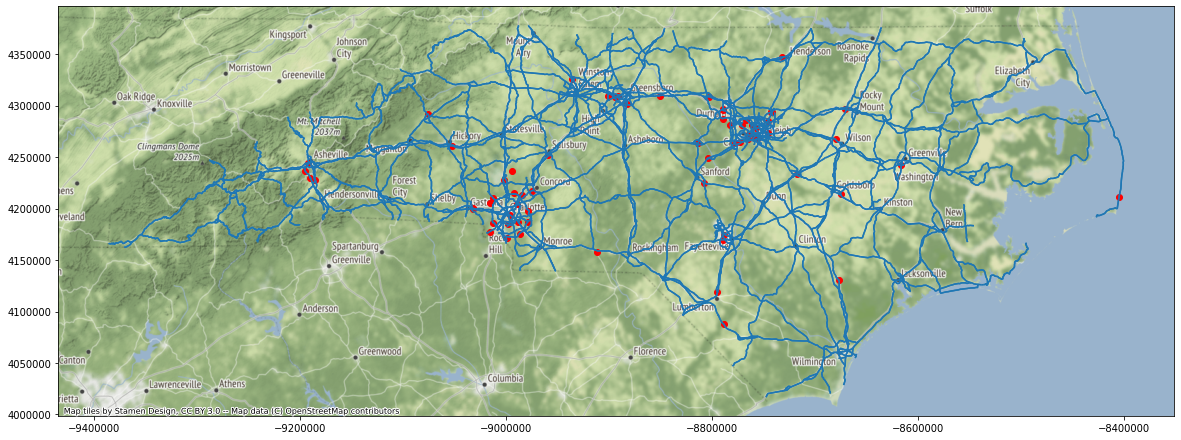

In [15]:
#Plot the data
ax = gdf_edges_wm.plot(figsize=(20,10))
gdf_DCFC_wm.plot(color='red',ax=ax)
ctx.add_basemap(ax)

## Identify "Anxious Areas"
What road segments are > 50 miles from a DCFC location? 

Source: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb

In [48]:
import networkx as nx

In [126]:
df_DCFC.shape

(68, 37)

In [127]:
polys = []
subgraphs = []
for i, row in df_DCFC.iterrows():
    #Get the coordinates
    thePoint = (row.latitude,row.longitude)
    #Get the ID
    theID = row.id
    #Get the nearest node
    theNode = ox.get_nearest_node(nc_graph,thePoint)
    #Get the subgraph
    subgraph = nx.ego_graph(nc_graph,theNode,radius=25*1609.34,distance='length')
    #Get the nodes in the subgraph
    node_points = [Point((data['x'],data['y'])) for node, data in subgraph.nodes(data=True)]
    #Get the bounding poly
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    #Add the polygon
    polys.append(bounding_poly)
    subgraphs.append(subgraph)
    #Export the subgraph
    # ox.save_graph_shapefile(subgraph,filename=f"sub{theID}",folder='Data/Subgraphs')

ValueError: Wrong number of items passed 0, placement implies 1

In [136]:
polys = []
subgraphs = []
from shapely.geometry import LineString
for i, row in df_DCFC.iterrows():
    #Get the coordinates
    thePoint = (row.latitude,row.longitude)
    #Get the ID
    theID = row.id
    #Get the nearest node
    theNode = ox.get_nearest_node(nc_graph,thePoint)
    #Get the subgraph
    subgraph = nx.ego_graph(nc_graph,theNode,radius=25*1609.34,distance='length')
    #Get the nodes in the subgraph
    node_points = [Point((data['x'],data['y'])) for node, data in subgraph.nodes(data=True)]
    
    # Buffer
    nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index('id')

    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lines.append(LineString([f,t]))

    n = nodes_gdf.buffer(50).geometry
    e = gpd.GeoSeries(edge_lines).buffer(50).geometry
    all_gs = list(n) + list(e)
    new_iso = gpd.GeoSeries(all_gs).unary_union

    # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
    #if infill:
    #    new_iso = Polygon(newa_iso.exterior)
    
    #Get the bounding poly
    #bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    #Add the polygon
    polys.append(new_iso)
    subgraphs.append(subgraph)
    #Export the subgraph
    # ox.save_graph_shapefile(subgraph,filename=f"sub{theID}",folder='Data/Subgraphs')

KeyError: 0

In [95]:
from descartes import PolygonPatch
import matplotlib.pyplot as plt

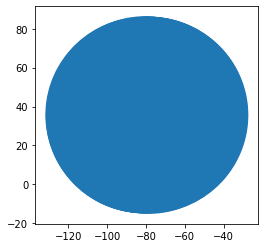

In [145]:
gpd.GeoSeries(polys).plot()

In [ ]:
for subgraph in subgraphs

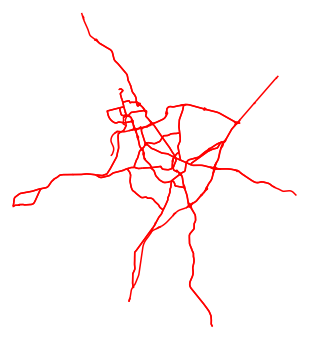

In [123]:
fig, ax = ox.plot_graph(nc_graph, fig_height=10,
                        show=False, edge_color='k', edge_alpha=0.2, node_color='none',close=True)
theLine = ox.plot_graph(subgraphs[1],edge_linewidth=1.5,node_color='none',edge_color='r')

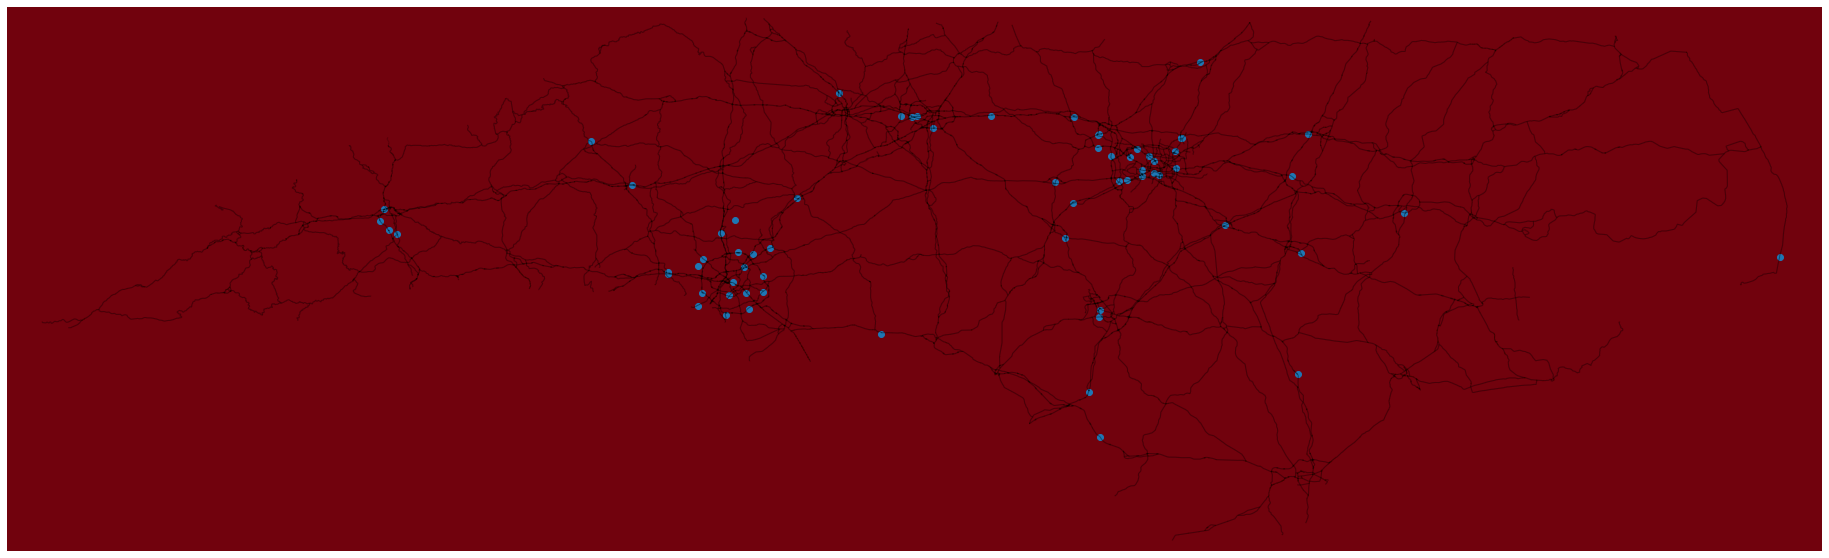

In [137]:
iso_colors = ox.get_colors(n=len(polys), cmap='Reds', start=0.3, return_hex=True)
fig, ax = ox.plot_graph(nc_graph, fig_height=10,show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(polys, iso_colors):
    if polygon.area > 0:
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
gdf_DCFC.plot(ax=ax)
plt.show()

In [129]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

ValueError: A polygon or multi-polygon representation is required

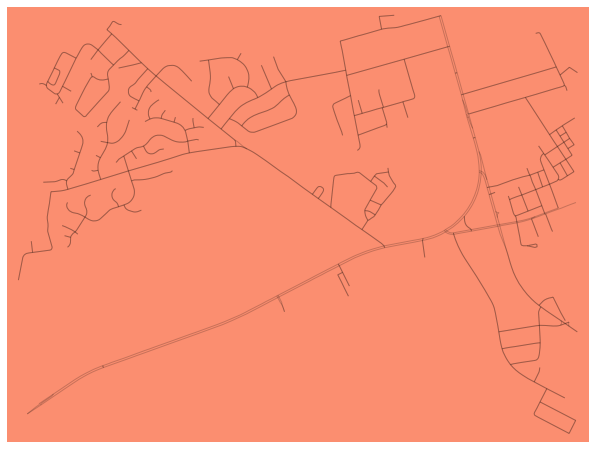

In [130]:
iso_colors = ox.get_colors(n=len(polys), cmap='Reds', start=0.3, return_hex=True)
fig, ax = ox.plot_graph(nc_graph, fig_height=10,show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## Next step:
The above figure reveals how far a car with 50 mile capacity 